In [13]:
# Plotting script for results
import os
import matplotlib.pyplot as plt
from read_results_helpers import *

In [14]:
total_hours = 8784
# Plotting results for cost and capacity
def plot_results(results_dir, color_dict, poi):
    max_result = 0
    fig, ax = plt.subplots(figsize=(10, 5))
    # Increase white space left and bottom
    fig.subplots_adjust(left=0.85, bottom=0.6)

    files = [f for f in os.listdir(results_dir) if f.endswith('.pickle')]
    files.pop(files.index('all_firm_all.pickle'))
    files_sorted = sorted(files, key=lambda x: int(x.split('_')[3]))
    files_sorted.insert(0, 'all_firm_all.pickle')

    # Loop over all case pickle files in all_firm_case folder
    for i,case_file in enumerate(files_sorted):

        if i==0 or len([x for x in results.values() if x != 0]) > 2:

            # Load results
            component_results = read_component_results(results_dir, case_file)
            # Calculate results
            results = get_result(component_results, total_hours, poi)
            # Sort results by value in descending order
            results = {k: v for k, v in sorted(results.items(), key=lambda item: item[1], reverse=True)}
            # Length of non-zero results
  
            # Stacked bar plot of results
            bottom_value = 0
            for component in results:
                if len([x for x in results.values() if x != 0]) != 2:
                    x_tick_label = files_sorted[i+1].replace('all_firm_', '').replace('.pickle', '').replace('remove_{0}_'.format(i), '')
                else:
                    x_tick_label = 'no firm'
                ax.bar(x_tick_label, results[component], width=0.25,
                        color=color_dict[component], bottom=bottom_value, label=component)
                bottom_value += results[component]

            print ("Results for ", case_file, poi)
            print (results)

            # Get max result
            if sum(results.values()) > max_result:
                max_result = sum(results.values())
            
            if case_file == 'all_firm_all.pickle':
                handles, labels = ax.get_legend_handles_labels()
                labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0].lower()))

    # Plot legend, label with second part of index of component_results, no box
    ax.legend(handles, labels, loc='upper left', fontsize='small', frameon=False, bbox_to_anchor=(1, 1))
    # Prevent legend from overlapping with plot
    fig.tight_layout()

    # Plot labels
    ax.set_xlabel('Firm technology with largest cost share')
    ax.set_ylabel('Total {0} [{1}]'.format(poi, '€' if poi == 'cost' else 'MW (/tCo2)'))
    ax.set_title('Total {0} of all cases'.format(poi))
    # Avoid x label overlap with x ticks by rotating, center upper end of label with tick
    plt.setp(ax.get_xticklabels(), rotation=40, ha='right', rotation_mode='anchor')


    n_cases = len([case for case in os.listdir(results_dir) if case.endswith('.pickle')])
    # Axis limits
    ax.set_ylim(0, 1.2*max_result)

    # Save plot
    fig.savefig('output_data/total_{0}.png'.format(poi))
    plt.show()

Results for  all_firm_all.pickle cost
{'hydro': 94008293596.09425, 'solar-utility': 9866821671.062216, 'battery storage': 8974196716.497873, 'natgas_wCCS': 2207899193.9309816, 'load shedding': 640968924.7248104, 'beccs': 121355551.39331362, 'CO2 storage tank': 0.0, 'direct air capture': 0.0, 'geothermal': 0.0, 'hydrogen': 0.0, 'load shifting backward': 0.0, 'load shifting forward': 0.0, 'natgas': 0.0, 'nuclear': 0.0, 'onwind': 0.0, 'phs': 0.0}
Results for  all_firm_remove_0_hydro.pickle cost
{'natgas_wCCS': 80676083755.6526, 'onwind': 72567018055.06473, 'solar-utility': 27425866235.3226, 'battery storage': 10175835753.545246, 'direct air capture': 3014082220.1551967, 'CO2 storage tank': 1452710134.9614625, 'beccs': 438641630.7369995, 'load shedding': 433822337.62980425, 'geothermal': 0.0, 'hydrogen': 0.0, 'load shifting backward': 0.0, 'load shifting forward': 0.0, 'nuclear': 0.0, 'phs': 0.0, 'natgas': -3.752137589371294e-08}
Results for  all_firm_remove_1_natgas_wCCS.pickle cost
{'geo

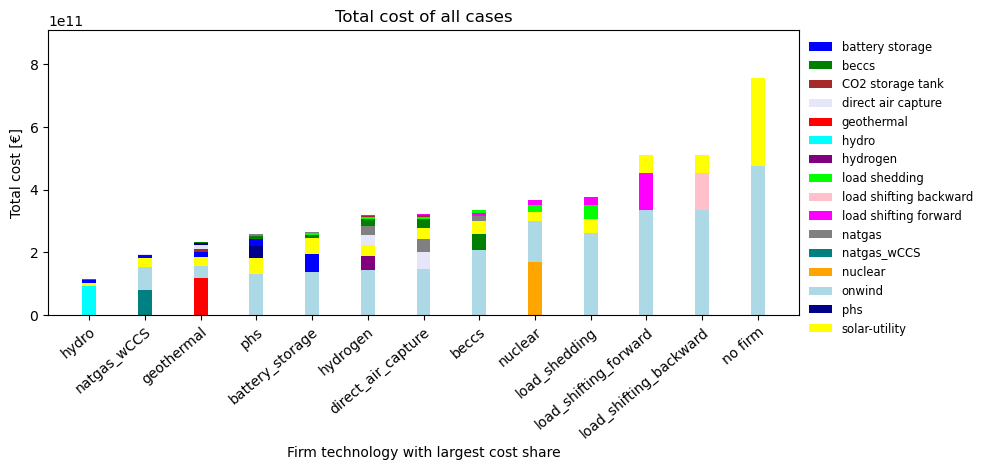

Results for  all_firm_all.pickle capacity
{'hydro': 530086.4347404382, 'solar-utility': 198973.05676258146, 'battery storage': 68299.40219586412, 'load shedding': 14945.222924981965, 'natgas_wCCS': 13383.861476963695, 'beccs': 109.70378259806309, 'CO2 storage tank': 0.0, 'direct air capture': 0.0, 'geothermal': 0.0, 'hydrogen': 0.0, 'load shifting backward': 0.0, 'load shifting forward': 0.0, 'natgas': 0.0, 'nuclear': 0.0, 'onwind': 0.0, 'phs': 0.0}
Results for  all_firm_remove_0_hydro.pickle capacity
{'CO2 storage tank': 5997351.568830684, 'onwind': 647288.2517084494, 'solar-utility': 553066.4910270274, 'natgas_wCCS': 343838.93968873366, 'battery storage': 77444.64722204817, 'load shedding': 16722.401223543024, 'direct air capture': 2992.385984813203, 'beccs': 365.5765672738793, 'geothermal': 0.0, 'hydrogen': 0.0, 'load shifting backward': 0.0, 'load shifting forward': 0.0, 'natgas': 0.0, 'nuclear': 0.0, 'phs': 0.0}
Results for  all_firm_remove_1_natgas_wCCS.pickle capacity
{'CO2 stor

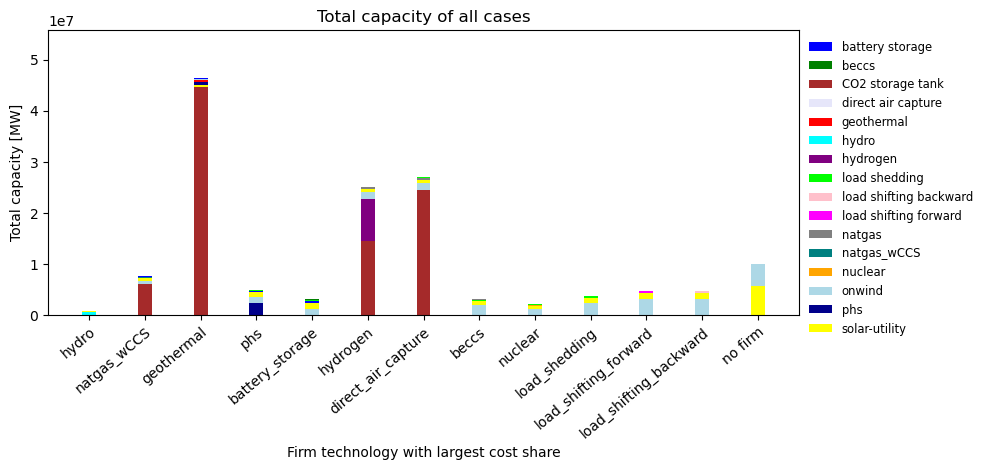

In [15]:
# Results directory
results_dir = 'output_data/all_firm_case'

# Get color map
all_comp = read_component_results(results_dir, 'all_firm_all.pickle').index
color_dict = get_colors(sorted(all_comp, key=lambda x: x.lower()))


# Plot
plot_results(results_dir, color_dict, 'cost')
plot_results(results_dir, color_dict, 'capacity')